# Проект "В один клик"

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель:**
разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

Таблица market_file, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица market_money с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

Таблица market_time с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

Таблица money с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

**План работы:**
- предобработка данных;
- исследовательский анализ данных для ознакомления с общей информацией о клиентах;
- объединение таблиц для совместного рассмотрения всех параметров, связанных с клиентами и их покупками;
- корреляционный анализ для выяснения степени важности влияния признаков клиента на его покупательскую активность;
- построение и выбор моделей для предсказания активности клиента по параметрам;
- анализ важности признаков в части их влияния на покупательскую активность;
- сегментация покупателей и предложения бизнесу;
- вывод.

**Загрузка и импорт используемых библиотек и их методов**

In [1]:
pip install phik --q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap --q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scikit-learn==1.1.3 --q

In [4]:
import sklearn
print(sklearn.__version__)

1.1.3


In [5]:
! pip install matplotlib==3.5.0 --q

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import shap

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

## Загрузка данных

In [7]:
market_file = pd.read_csv('market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_money = pd.read_csv('market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
market_time = pd.read_csv('market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
money = pd.read_csv('money.csv', sep=';')
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Данные во всех таблицах соответствуют описанию. Однако, в таблице money разделителем в десятичных дробях является запятая. Это также необходимо будет учесть при предобработке данных.

## Предобработка данных

### market_file

In [11]:
# общая информация о market_file
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В датафрейме market_file 13 столбцов. Пропущенных значений нет. Типов столбцов соответствуют содержащимся в них значениям. Необходимо проверить датафрейм на дубликаты, но сначала изменим наименования столбцов.

In [12]:
market_file.columns = ['id', 'покуп_активн', 'тип_сервис', 'разреш_сообщ', 'маркет_актив_6_мес',
                       'маркет_актив_тек_мес', 'длител_на_сайте', 'акц_покупки',  'популярн_категория',
                       'средн_просм_катег_визит', 'неопл_прод_шт_квартал', 'ошибка_сервиса', 'стр_визит']
market_file.columns

Index(['id', 'покуп_активн', 'тип_сервис', 'разреш_сообщ',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длител_на_сайте',
       'акц_покупки', 'популярн_категория', 'средн_просм_катег_визит',
       'неопл_прод_шт_квартал', 'ошибка_сервиса', 'стр_визит'],
      dtype='object')

Наименование изменены. Теперь проверим данные на дубликаты. Начнем с неявных дубликатов в уникальных значениях столбцов.

In [13]:
market_file['покуп_активн'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [14]:
market_file['тип_сервис'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Видим неявный дубликат "стандартт" и "стандарт". Заменим первое на второе.

In [15]:
market_file['тип_сервис'] = market_file['тип_сервис'].replace('стандартт', 'стандарт')
market_file['тип_сервис'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [16]:
market_file['разреш_сообщ'].unique()

array(['да', 'нет'], dtype=object)

In [17]:
market_file['маркет_актив_6_мес'].unique()

array([3.4, 4.4, 4.9, 3.2, 5.1, 3.3, 4.7, 4.2, 3.9, 4.6, 4.3, 3.8, 2.7,
       4.8, 2.9, 3. , 2.4, 1.7, 3.6, 4. , 1.5, 3.5, 4.1, 3.1, 1.4, 0.9,
       5.6, 2.6, 5.5, 5.2, 5.8, 5. , 5.4, 5.7, 5.3, 3.7, 6.3, 6.6, 4.5,
       6.1, 5.9])

In [18]:
market_file['маркет_актив_тек_мес'].unique()

array([5, 4, 3], dtype=int64)

In [19]:
market_file['длител_на_сайте'].unique()

array([ 121,  819,  539,  896, 1064,  762,  431,  284,  192,  154,  450,
        110,  623,  199,  438,  923,  708,  167,  209,  581,  829,  607,
        572,  365,  566,  811,  268,  558,  534,  730,  488,  436,  637,
        554,  330,  504, 1020,  721,  495,  135,  663, 1047,  152,  754,
        525,  169,  966,  645,  706,  689,  882, 1007,  304,  339,  954,
        771,  699,  669,  511,  974,  666,  857, 1048,  756,  506,  759,
        768,  720,  219,  377,  472,  806,  449,  523,  503,  515,  813,
        249,  186,  336,  690,  824,  753,  674,  875,  844,  602,  855,
        448,  344,  922,  298,  893,  881,  372,  788,  937,  764,  851,
       1021,  627,  748,  684,  719,  891,  842,  573, 1057,  342,  638,
        458,  254,  600,  871,  574,  982,  324,  373,  839,  845,  475,
        509,  252,  820,  744,  541, 1079,  900,  474,  957,  773,  717,
        508,  184,  828,  944,  419,  302,  898,  705,  953,  355,  616,
        622,  335, 1025,  755,  549,  308,  903,  6

In [20]:
market_file['акц_покупки'].unique()

array([0.  , 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17, 0.13, 0.35, 0.74,
       0.29, 0.98, 0.95, 0.22, 0.4 , 0.24, 0.21, 0.39, 0.9 , 0.89, 0.27,
       0.33, 0.34, 0.32, 0.93, 0.3 , 0.28, 0.31, 0.25, 0.36, 0.16, 0.11,
       0.2 , 0.18, 0.15, 0.6 , 0.12, 0.19, 0.44, 0.47, 0.91])

In [21]:
market_file['популярн_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [22]:
market_file['средн_просм_катег_визит'].unique()

array([6, 4, 5, 3, 2, 1], dtype=int64)

In [23]:
market_file['неопл_прод_шт_квартал'].unique()

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7], dtype=int64)

In [24]:
market_file['ошибка_сервиса'].unique()

array([1, 2, 6, 3, 7, 9, 4, 5, 8, 0], dtype=int64)

In [25]:
market_file['стр_визит'].unique()

array([ 5,  4,  2,  3,  7,  1,  6,  8,  9, 14, 11, 15, 16, 10, 17, 13, 12,
       18, 19, 20], dtype=int64)

Нашли неявный дубликат в столбце с типом сервиса и заменили его. Теперь проверим датафрейм на полные дубликаты по строкам.

In [26]:
market_file.duplicated().sum()

0

Полные строковые дубликаты отсутствуют. Теперь проверим дубликаты в столбце ```id```.

In [27]:
market_file.duplicated(subset=['id']).sum()

0

Дубликатов по ```id``` также нет.

### market_money

Рассмотрим датафрейм ```market_money```.

In [28]:
# общая информация
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В датафрейме всего 3 столбца. Пропуски отсутствуют. Тип данных совпадает с описанием. Изменим наименования столбцов.

In [29]:
market_money.columns = ['id', 'период', 'выручка']
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

Проверим значения в столбцах.

In [30]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Дубликатов нет. Имеем данные за три крайних месяца.

In [31]:
market_money['выручка'].unique()

array([   0. , 3293.1, 4472. , ..., 5224.6, 4720. , 4448.3])

Проверим полные дубликаты по строкам.

In [32]:
market_money.duplicated().sum()

0

Дубликаты отсутствуют. Посмотрим нет ли дубликатов среди ```id``` и ```период```.

In [33]:
market_money.duplicated(subset=['id', 'период']).sum()

0

Дубликаты в ```market_money``` отсутствуют. Таким образом, изменили только наименования столбцов.

### market_time

In [34]:
# общая информация
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропусков нет. Изменим наименования столбцов.

In [35]:
market_time.columns = ['id', 'период', 'мин']
market_time.columns

Index(['id', 'период', 'мин'], dtype='object')

In [36]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Дубликатов нет. Но исправим орфографию в значении предыдущего месяца.

In [37]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [38]:
market_time['мин'].unique()

array([14, 13, 10, 12,  8, 11,  6,  7,  9,  5, 15,  4, 16, 17, 19, 18, 22,
       20, 21, 23], dtype=int64)

Проверим дубликаты на подмножестве ```id, период```.

In [39]:
market_time.duplicated(subset=['id', 'период']).sum()

0

Дубликатов нет.

### money

In [40]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Пропусков нет. Необходимо изменить наименования столбцов и изменить тип данных в столбце ```Прибыль```.

In [41]:
money.columns = ['id', 'прибыль']
money.columns

Index(['id', 'прибыль'], dtype='object')

Прибыль записана через знак запятой. Заменим запятую на точку и преобразуем в численный тип.

In [42]:
money['прибыль'] = pd.to_numeric(money['прибыль'].str.replace(',', '.'))
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тип значений изменен. Теперь проверим дубликаты в ```id```.

In [43]:
money.duplicated(subset=['id']).sum()

0

Дубликаты отсутствуют. Таким образом, была проведена предобработка данных. Для четырех датафреймов были изменены наименования столбцов, удалены неявные дубликаты и изменен тип столбца со строкового на численный.

## Исследовательский анализ данных

Проведем исследовательский анализ данных для каждого датафрейма.

Так как в постановке задачи речь идет об удержании постоянных клиентов, удалим из данных тех клиентов, которые не совершали покупки за последние 3 месяца.

In [44]:
# получим id тех покупателей у кого есть хоть один ноль в столбце выручка
zero_rev_id = market_money[market_money['выручка'] == 0]['id'].unique()
zero_rev_id

array([215348, 215357, 215359], dtype=int64)

Были найдены три клиента, которые не покупали товары все три месяца. Удалим их из всех датафреймов.

In [45]:
market_file = market_file[~market_file['id'].isin(zero_rev_id)].reset_index(drop=True)
display(market_file.head())
market_file.shape[0]

,id,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


1297

Три клиента удалены. Теперь проведем аналогичную операцию для остальных трех датафреймов.

In [46]:
market_money = market_money[~market_money['id'].isin(zero_rev_id)].reset_index(drop=True)
display(market_money.head())
market_money.shape[0]

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0
1,215349,текущий_месяц,4971.6
2,215349,предыдущий_месяц,5216.0
3,215350,препредыдущий_месяц,4826.0
4,215350,текущий_месяц,5058.4


3891

In [47]:
market_time = market_time[~market_time['id'].isin(zero_rev_id)].reset_index(drop=True)
display(market_time.head())
market_time.shape[0]

,id,период,мин
0,215349,текущий_месяц,10
1,215349,предыдущий_месяц,12
2,215350,текущий_месяц,13
3,215350,предыдущий_месяц,8
4,215351,текущий_месяц,13


2594

In [48]:
money = money[~money['id'].isin(zero_rev_id)].reset_index(drop=True)
display(money.head())
money.shape[0]

,id,прибыль
0,215349,4.16
1,215350,3.13
2,215351,4.87
3,215352,4.21
4,215353,3.95


1297

Таким образом, удалили данные о трех клиентах, которые не были активны на протяжении всех трех месяцев, из всех датафреймов.

### market_file

In [49]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1297 non-null   int64  
 1   покуп_активн             1297 non-null   object 
 2   тип_сервис               1297 non-null   object 
 3   разреш_сообщ             1297 non-null   object 
 4   маркет_актив_6_мес       1297 non-null   float64
 5   маркет_актив_тек_мес     1297 non-null   int64  
 6   длител_на_сайте          1297 non-null   int64  
 7   акц_покупки              1297 non-null   float64
 8   популярн_категория       1297 non-null   object 
 9   средн_просм_катег_визит  1297 non-null   int64  
 10  неопл_прод_шт_квартал    1297 non-null   int64  
 11  ошибка_сервиса           1297 non-null   int64  
 12  стр_визит                1297 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 131.9+ KB


In [50]:
# получим общую статистическую информацию
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1297.0,215998.986893,374.578554,215349.00,215675.00,215999.00,216323.0,216647.00
маркет_актив_6_мес,1297.0,4.254433,1.015618,0.90,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1297.0,4.009252,0.696048,3.00,4.00,4.00,4.0,5.00
длител_на_сайте,1297.0,602.993832,249.101456,121.00,410.00,607.00,806.0,1079.00
акц_покупки,1297.0,0.320547,0.249657,0.11,0.17,0.24,0.3,0.99
средн_просм_катег_визит,1297.0,3.267540,1.354623,1.00,2.00,3.00,4.0,6.00
неопл_прод_шт_квартал,1297.0,2.841172,1.973451,0.00,1.00,3.00,4.0,10.00
ошибка_сервиса,1297.0,4.184271,1.950973,0.00,3.00,4.00,6.0,9.00
стр_визит,1297.0,8.186584,3.977061,1.00,5.00,8.00,11.0,20.00


In [51]:
# функция для графика пирога для категориальных параметров
def categ_analysis(df, column):
    display(df[column].value_counts().to_frame())
    df[column].value_counts().plot.pie(autopct='%1.1f%%')

#### ```покуп_активн```

,покуп_активн
Прежний уровень,802
Снизилась,495


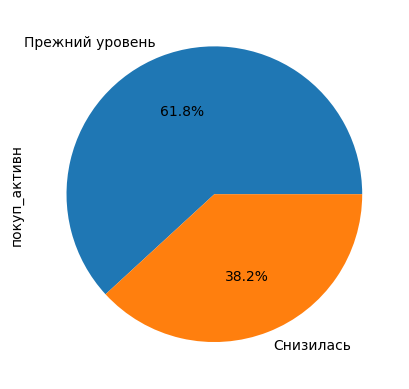

In [52]:
categ_analysis(market_file, 'покуп_активн')

У большинства клиентов покупательская активность осталась на прежнем уровне. Тем не менее, процент клиентов, у которых активность снизилась большой и равен 38.2%.

#### ```тип_сервис```

,тип_сервис
стандарт,922
премиум,375


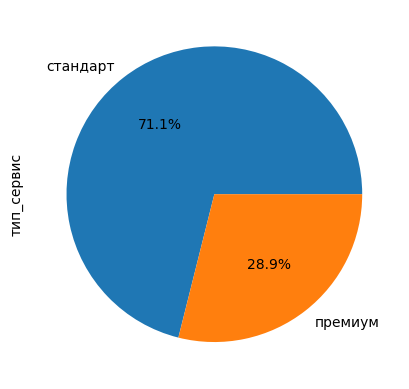

In [53]:
categ_analysis(market_file, 'тип_сервис')

У большинства покупателей стандартный тип сервиса, что неудивительно. Хотя информации об этом и нет, но скорее всего, за премиум сервис взимается дополнительная плата. Поэтому и процент клиентов с премиум сервисом (28.9%) можно назвать высоким.

Посмотрим на параметр снижения покупательской активности относительно типа сервиса.

,покуп_активн
Прежний уровень,596
Снизилась,326


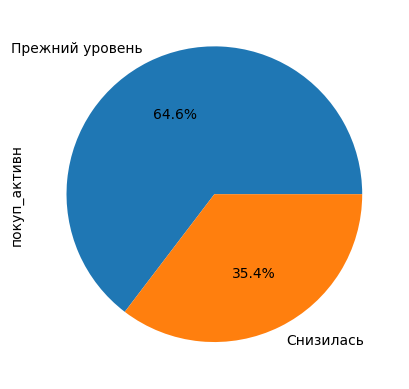

In [54]:
categ_analysis(market_file[market_file['тип_сервис'] == 'стандарт'], 'покуп_активн')

,покуп_активн
Прежний уровень,206
Снизилась,169


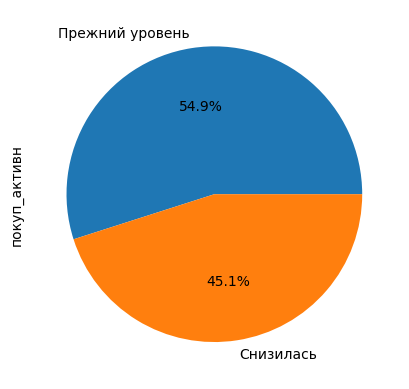

In [55]:
categ_analysis(market_file[market_file['тип_сервис'] == 'премиум'], 'покуп_активн')

Видим, что среди покупателей с типом сервиса "премиум" больший процент тех, у кого снизилась покупательская активность.

#### ```разреш_сообщ```

,разреш_сообщ
да,959
нет,338


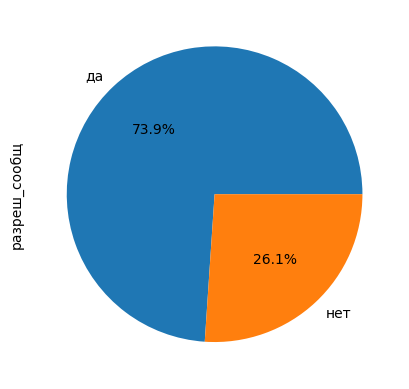

In [56]:
categ_analysis(market_file, 'разреш_сообщ')

Для большинства клиентов имеется разрешение на получение рекламных уведомлений.

,покуп_активн
Прежний уровень,591
Снизилась,368


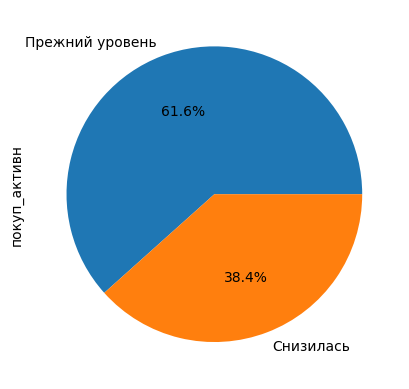

In [57]:
categ_analysis(market_file[market_file['разреш_сообщ'] == 'да'], 'покуп_активн')

,покуп_активн
Прежний уровень,211
Снизилась,127


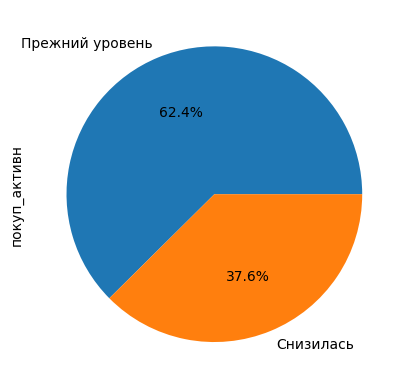

In [58]:
categ_analysis(market_file[market_file['разреш_сообщ'] == 'нет'], 'покуп_активн')

В зависимости от разрешения на сообщения процент снижения активности не сильно изменился. Возможно, этот параметр не сильно влияет на активность.

#### ```популярн_категория```

,популярн_категория
Товары для детей,329
Домашний текстиль,250
Косметика и аксесуары,223
Техника для красоты и здоровья,183
Мелкая бытовая техника и электроника,174
Кухонная посуда,138


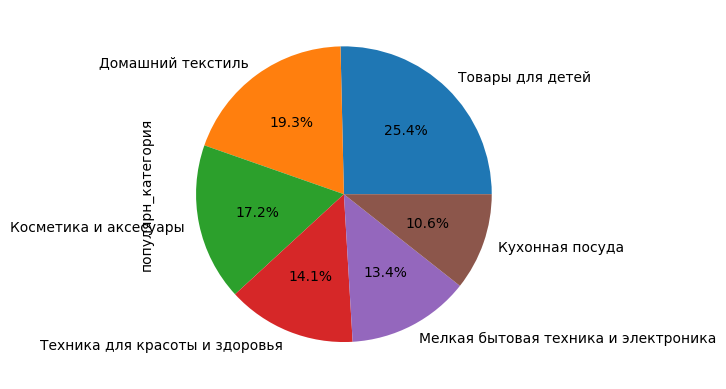

In [59]:
categ_analysis(market_file, 'популярн_категория')

Большой разницы между категориями не наблюдается. Однако, в топ-3 входят "Товары для детей", "Домашний текстиль" и "Косметика и аксесуары".

,популярн_категория
Товары для детей,184
Домашний текстиль,149
Мелкая бытовая техника и электроника,147
Техника для красоты и здоровья,132
Косметика и аксесуары,118
Кухонная посуда,72


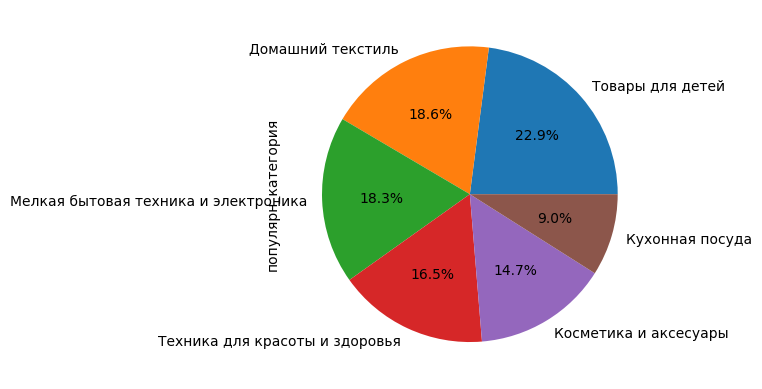

In [60]:
categ_analysis(market_file[market_file['покуп_активн'] == 'Прежний уровень'], 'популярн_категория')

,популярн_категория
Товары для детей,145
Косметика и аксесуары,105
Домашний текстиль,101
Кухонная посуда,66
Техника для красоты и здоровья,51
Мелкая бытовая техника и электроника,27


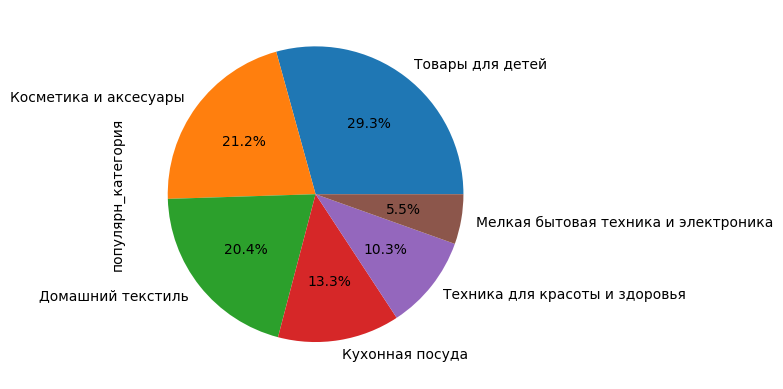

In [61]:
categ_analysis(market_file[market_file['покуп_активн'] == 'Снизилась'], 'популярн_категория')

Видим, что в зависимости от покупательской активности, разное распределение наиболее популярных категорий. Наиболее явное различие видно в категориях "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья". У прежнего уровня активности эти категории занимают третье и четвертое место по популярности. Тогда как у тех у кого активность снизилась это 2 наименее популярные категории. То есть покупательская активность осталось прежней у клиентов, покупающих товары с длинным жизненным циклом.

Теперь рассмотрим количественные признаки.

#### ```маркет_актив_6_мес```

In [62]:
# функция для построения гистограммы и диаграммы размаха
def quant_analysis(df, column, bins=20):
    df[column].hist(bins=bins)
    plt.title(column)
    plt.ylabel('частота')
    plt.show()
    df.boxplot(column)

Text(0.5, 1.0, 'Распределение среднемесячного значения маркетинговых коммуникаций')

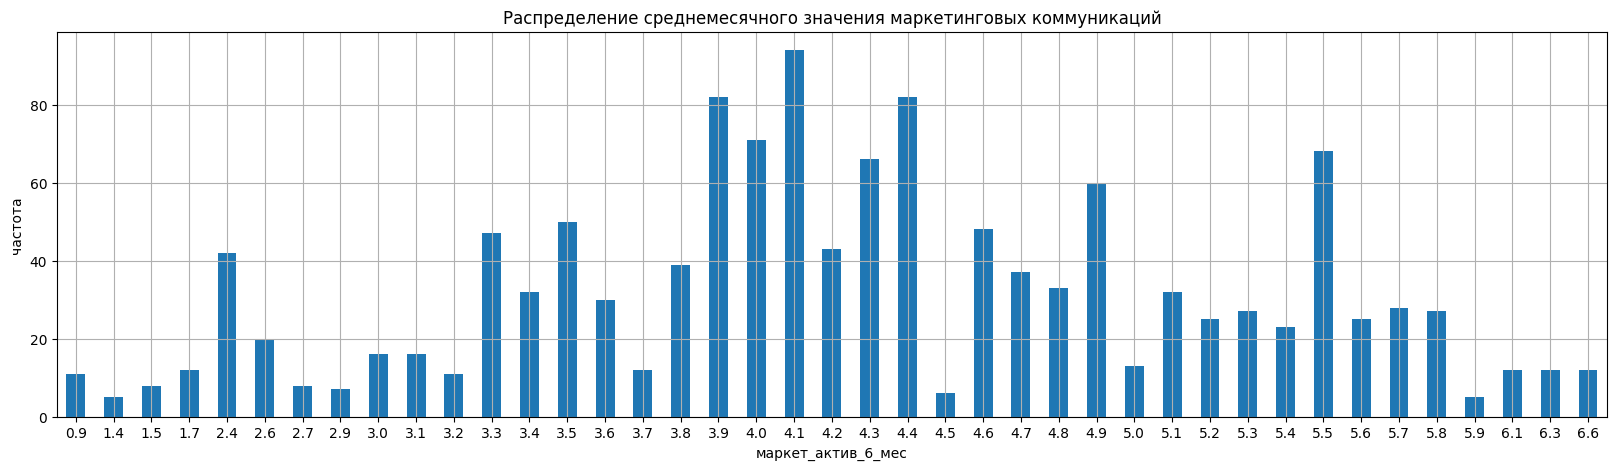

In [63]:
market_file.groupby('маркет_актив_6_мес')['маркет_актив_6_мес'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('частота')
plt.title('Распределение среднемесячного значения маркетинговых коммуникаций')

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Привет! Спасибо за первый этап ревью. Добавляю выше на графике подписи.</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено. Но хочу обратить твое внимание на то, что  одинаковые "обезличенные" подписи на всех графиках - это не ОК. Графики принято подписывать так, чтобы подписи **отражали суть** изображенного на осях, а также подписи должны содержать и единицы измерения того, что на осях изображено.
</div>

Наиболее высокие пики видим в районе 4 рекламных уведомлений. Также видим большие пики по-сравнению с соседними значениями для 2.4 и 5.5. Возможно, при сборе, данные округляли не по типичному математическому округлению, в результате чего и получились такие пики.

#### ```маркет_актив_тек_мес```

Text(0.5, 1.0, 'Распределение маркетинговой активности в текущем месяце')

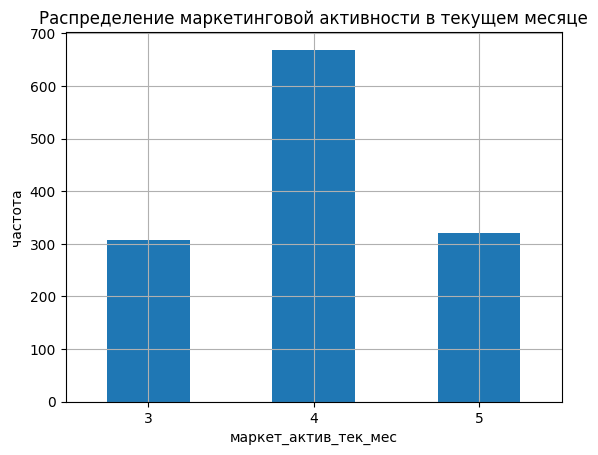

In [64]:
market_file.groupby('маркет_актив_тек_мес')['маркет_актив_тек_мес'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение маркетинговой активности в текущем месяце')

За последний месяц компания рассылала рекламные уведомления в количестве 3, 4 и 5 раз для каждого пользователя. Примерно в равном количестве по 3 и 5 раз. Наибольшее количество клиентов получило 4 уведомления.

#### ```длител_на_сайте```

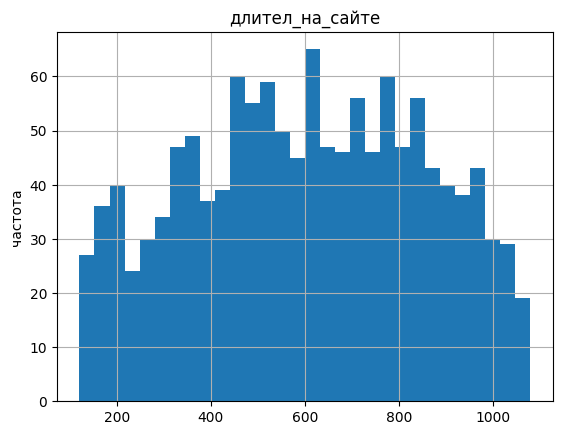

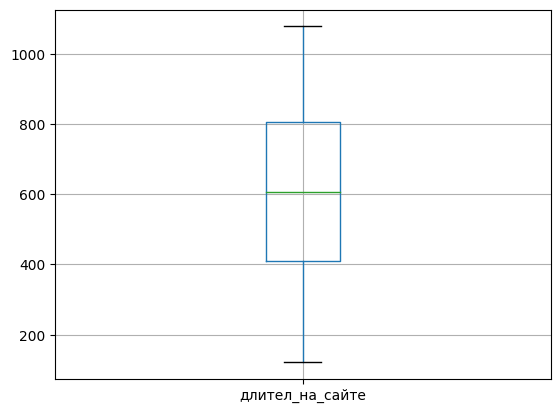

In [65]:
quant_analysis(market_file, 'длител_на_сайте', 30)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично!  Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о **возможных выбросах** (пишу **возможных**, потому что нужно анализировать бизнесовый смысл значений показанных как выбросы ... просто так удалять то, что показывает боксплот за пределами 1,5 IQR от границ "ящика" - неверно) и основных статистиках (квартилях) признака.
</div>


Количество дней с момента регистрации не имеет выбросов. В целом распределение напоминает что-то среднее между нормальным и равномерным, что ожидаемо для такого параметра.

#### ```акц_покупки```

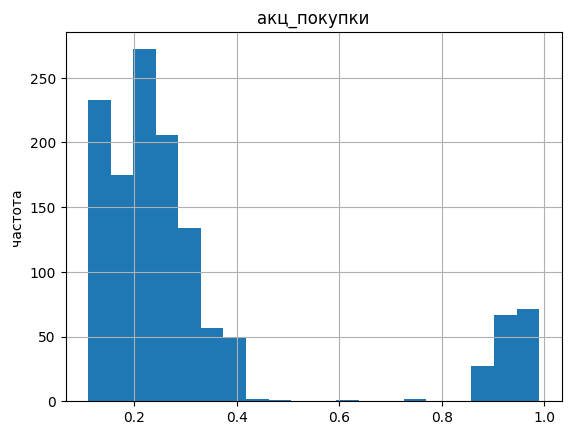

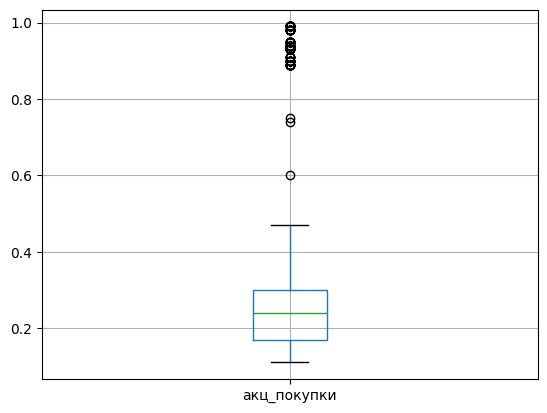

In [66]:
quant_analysis(market_file, 'акц_покупки')

В данных по акционным покупкам есть выбросы. Есть клиенты, которые практически все свои покупки делали по акции. Однако, удалять их не будем, так как в принципе такое возможно, действительно есть люди, которые пользуется только акциями для покупок.

#### ```средн_просм_катег_визит```

Text(0.5, 1.0, 'Распределение среднего просмотра категорий за визит')

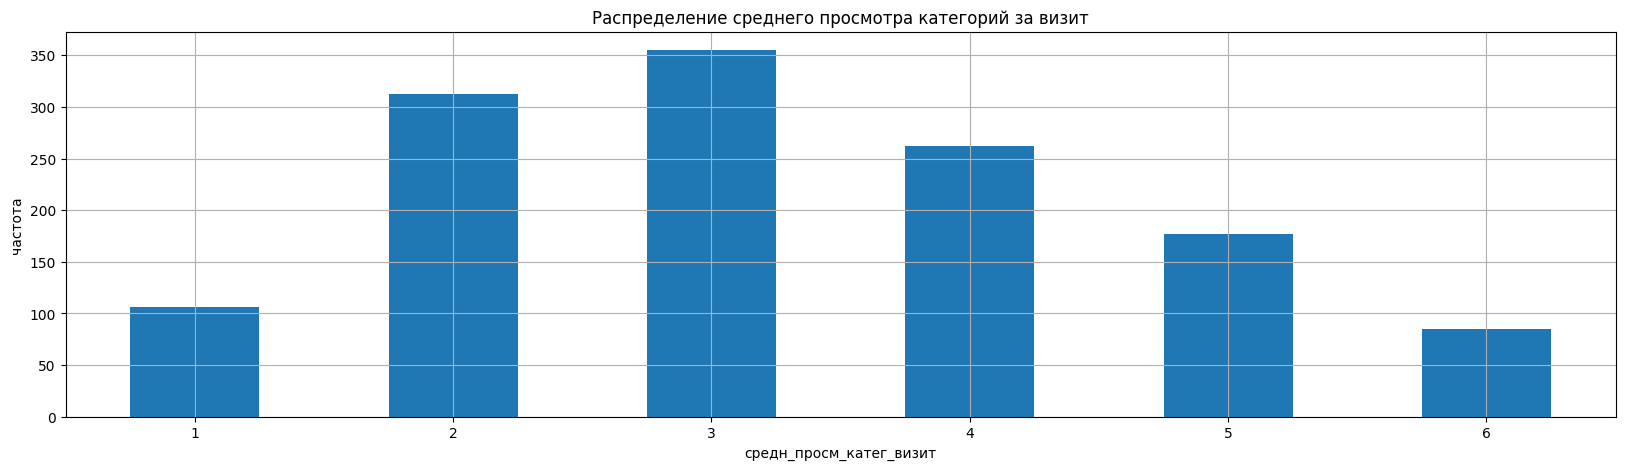

In [67]:
market_file.groupby('средн_просм_катег_визит')['средн_просм_катег_визит'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('частота')
plt.title('Распределение среднего просмотра категорий за визит')

Видимо, данные по просмотрам округляют, так как присутствуют только целые числы. Наиболее частое явление это просмотр 3 категорий за визит. То есть, люди часто посещают сайт не в поисках какого-то конкретного товара определенной категории, а просто в поисках чего-либо, что может их заинтересовать.

#### ```неопл_прод_шт_квартал```

Text(0.5, 1.0, 'Распределение количества неоплаченных покупок в корзине (шт)')

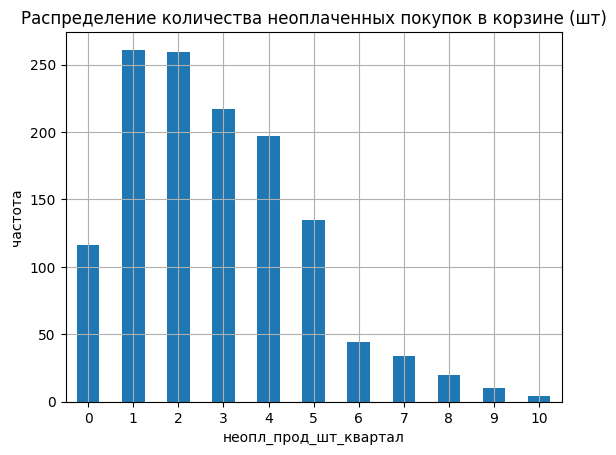

In [68]:
market_file.groupby('неопл_прод_шт_квартал')['неопл_прод_шт_квартал'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение количества неоплаченных покупок в корзине (шт)')

Картина по неоплаченным товарам в корзине выглядит реалистичной. Наиболее часто встречается количество товаров от 0 до 5. Далее идет резкий спад. Есть клиенты и с 10 неоплаченными товарами. Причина может быть в отсутствии возможности добавления желаемых товаров в отдельный список. Возможно, стоит рассмотреть создание такой возможности, если она действительно отсутствует.

#### ```ошибка_сервиса```

Text(0.5, 1.0, 'Распределение количества ошибок сервиса')

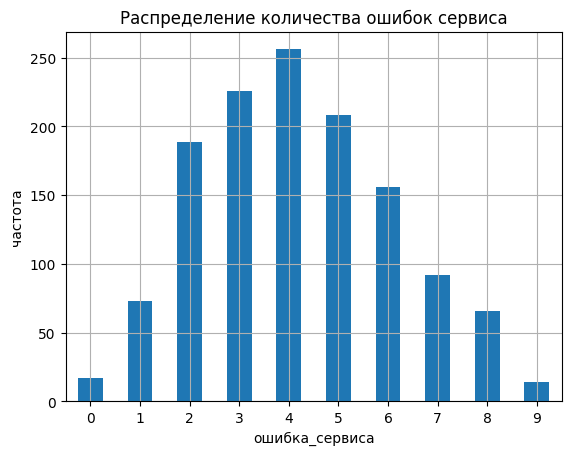

In [69]:
market_file.groupby('ошибка_сервиса')['ошибка_сервиса'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение количества ошибок сервиса')

Количество ошибок сервиса имеет нормальное распределение по клиентам. Наибольшее количество клиентов сталкивалось с 4мя ошибками при посещении сайта.

#### ```стр_визит```

Text(0, 0.5, 'Частота')

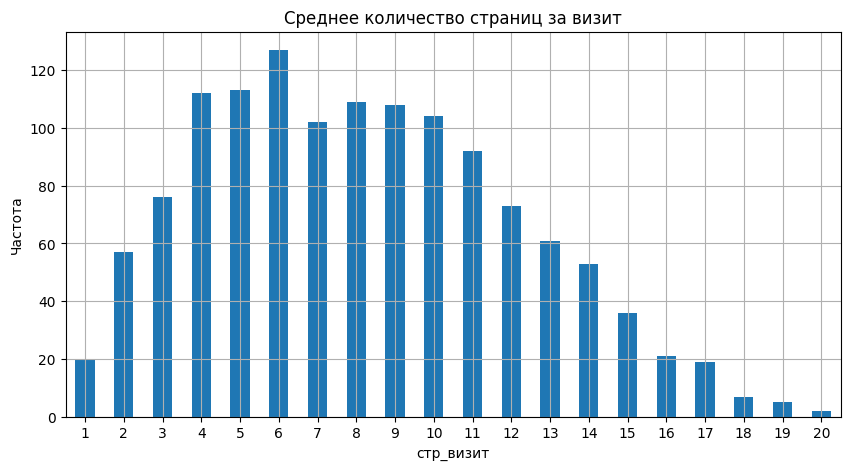

In [70]:
market_file.groupby('стр_визит')['стр_визит'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.title('Среднее количество страниц за визит')
plt.ylabel('Частота')

Среднее количество просмотренных страниц за визит имеет нормальное распределение. Так как данных мало, трудно оценить точно, но возможно здесь также может идти речь о бимодальном распределении.

### market_money

Сначала преобразуем таблицу, что в том числе понадобится далее для объединения таблиц. Преобразуем периоды в столбцы.

In [71]:
# создадим новый столбец по каждому периоду для каждой строки
# записываем выручку, если наименование нового столбца совпадает с периодом
market_money['препредыдущий_месяц'] = (market_money
                    .apply(lambda x: x['выручка'] if x['период'] == 'препредыдущий_месяц' else 0, axis=1))
market_money['предыдущий_месяц'] = (market_money
                    .apply(lambda x: x['выручка'] if x['период'] == 'предыдущий_месяц' else 0, axis=1))
market_money['текущий_месяц'] = (market_money
                    .apply(lambda x: x['выручка'] if x['период'] == 'текущий_месяц' else 0, axis=1))
# группируем по id и суммируем для столбцов по выручке
market_money = (market_money.groupby('id')
    .agg({'препредыдущий_месяц':'sum', 'предыдущий_месяц':'sum', 'текущий_месяц':'sum', 'выручка':'sum'}))
# переименуемые столбцы
market_money.columns = ['препредыдущий_месяц_выр', 'предыдущий_месяц_выр', 'текущий_месяц_выр', 'всего_выр']
market_money.head(15)

,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,всего_выр
id,,,,
215349,4472.0,5216.0,4971.6,14659.6
215350,4826.0,5457.5,5058.4,15341.9
215351,4793.0,6158.0,6610.4,17561.4
215352,4594.0,5807.5,5872.5,16274.0
215353,5124.0,4738.5,5388.5,15251.0
215354,4503.0,5685.0,5869.6,16057.6
215355,4749.0,3263.0,3772.6,11784.6
215356,4433.0,4146.5,4566.4,13145.9
215358,4727.0,3488.0,4209.5,12424.5


Получили датафрейм в котором по каждому клиенту в строке записана выручка за последние 3 месяца и общая выручка за эти 3 месяца. Теперь id используется в качестве индекса. Так и оставим. Проведем исследовательский анализ для получившегося датафрейма.

#### ```препредыдущий_месяц_выр```

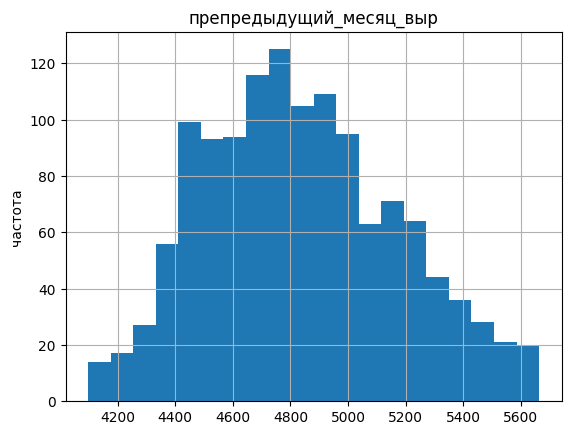

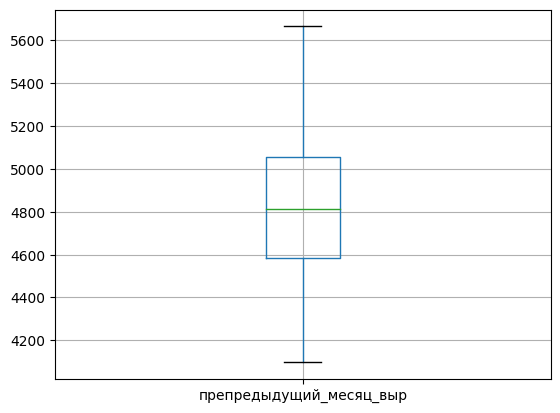

In [72]:
quant_analysis(market_money, 'препредыдущий_месяц_выр')

Видим, что выбросов по значениям выручки нет. Медианное значение, согласно диаграмме размаха, находится в районе 4800.

#### ```предыдущий_месяц_выр```

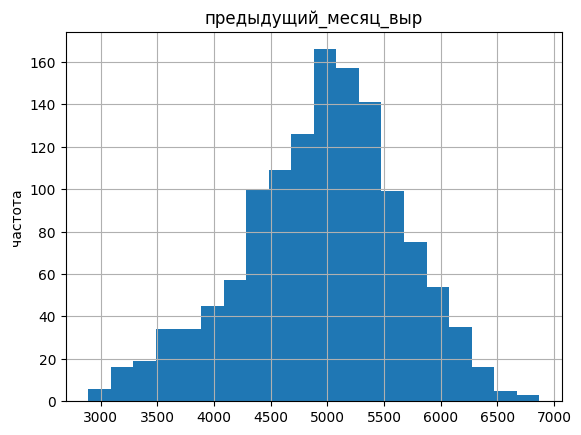

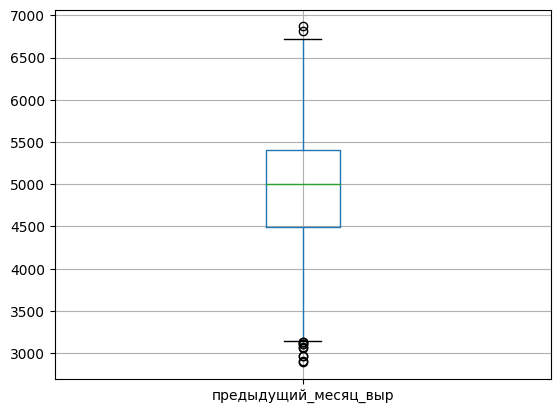

In [73]:
quant_analysis(market_money, 'предыдущий_месяц_выр')

За предыдущий месяц выручка также имеет нормальное распределение. Однако, появились выбросы. Но они не слишком далеки от медианного значения, всего 2000 тысячи. Поэтому удалять их не будем.

#### ```текущий_месяц_выр```

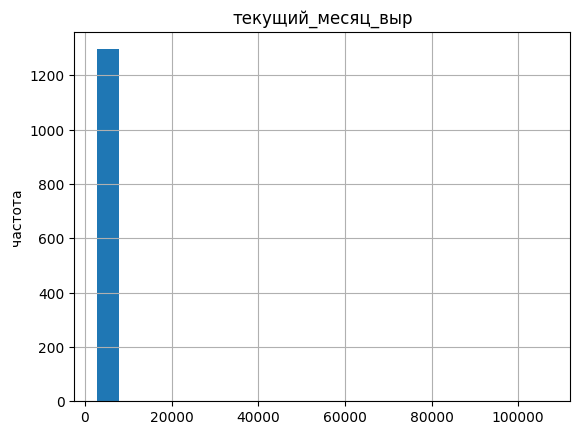

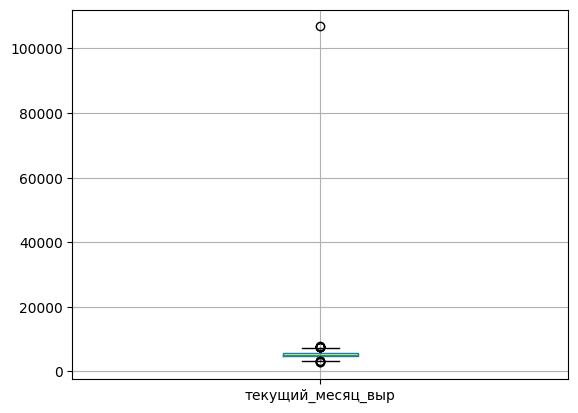

In [74]:
quant_analysis(market_money, 'текущий_месяц_выр')

In [75]:
market_money['текущий_месяц_выр'].describe()

count      1297.000000
mean       5316.449268
std        2942.469139
min        2758.700000
25%        4706.600000
50%        5180.300000
75%        5761.300000
max      106862.200000
Name: текущий_месяц_выр, dtype: float64

По текущему месяцу есть очень большой выброс в 106 тысяч, тогда как все остальные данные не превышают 10 тысяч, судя по диаграмме размаха. Удалим этого клиента из датафрейма.

In [76]:
# id выброса для удаления в остальных датафреймах
id_2_del = market_money[market_money['текущий_месяц_выр'] == market_money['текущий_месяц_выр'].max()].index[0]
id_2_del

215380

In [77]:
market_money = market_money[~(market_money['текущий_месяц_выр'] == market_money['текущий_месяц_выр'].max())]

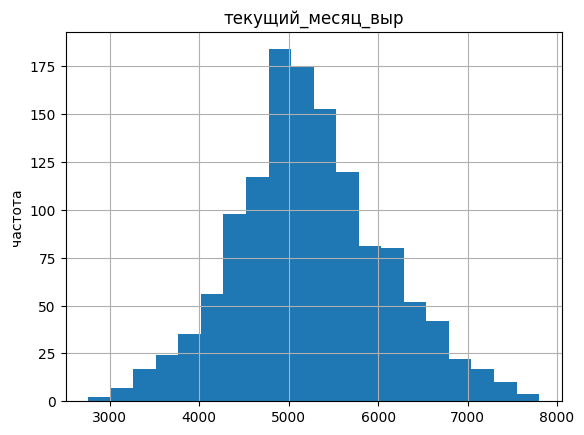

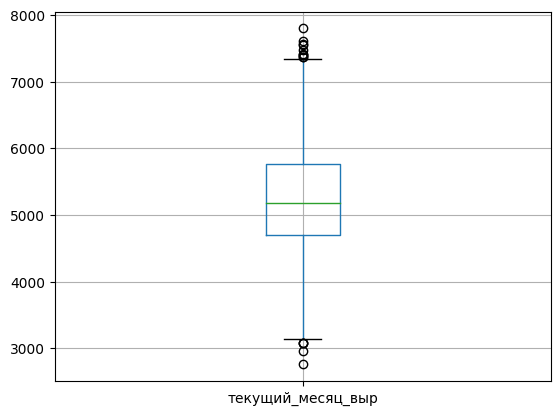

In [78]:
quant_analysis(market_money, 'текущий_месяц_выр')

Распределение в текщем месяце нормальное. Есть выбросы, но не будем их удалять, так как они не так существенны. В целом же видим, что максимальное значение выручки увеличивалось каждый месяц. Однако наиболее частое в текущем месяце значение находитсся в районе 5 тысяч, как и в предыдущем месяце.

Теперь удалим клиента с этим id в других датафреймах.

In [79]:
print(f'market_file - {market_file.shape[0]}')
market_file = market_file[market_file['id'] != id_2_del]
print(f'market_file - {market_file.shape[0]}')

market_file - 1297
market_file - 1296


In [80]:
print(f'market_time - {market_time.shape[0]}')
market_time = market_time[market_time['id'] != id_2_del]
print(f'market_time - {market_time.shape[0]}')

market_time - 2594
market_time - 2592


In [81]:
print(f'money - {money.shape[0]}')
money = money[money['id'] != id_2_del]
print(f'money - {money.shape[0]}')

money - 1297
money - 1296


В остальных датафреймах клиент с выбросом удален.

#### ```всего_выр```

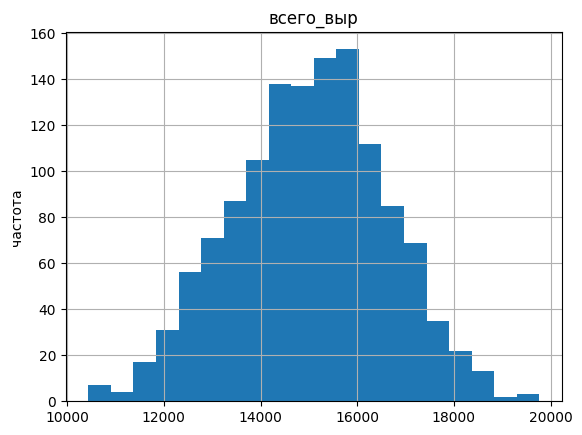

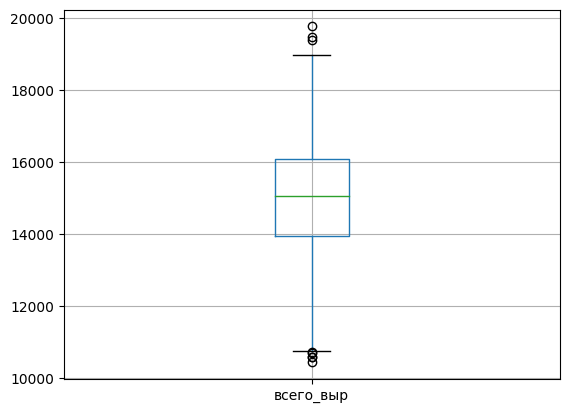

In [82]:
quant_analysis(market_money, 'всего_выр')

Суммарная выручка за 3 месяца имеет нормальное распределение.

### market_time

In [83]:
market_time.columns

Index(['id', 'период', 'мин'], dtype='object')

In [84]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Аналогично преобразуем периоды в столбцы.

In [85]:
# создадим новый столбец по каждому периоду для каждой строки
# записываем минуты, если наименование нового столбца совпадает с периодом
market_time['предыдущий_месяц'] = (market_time
                    .apply(lambda x: x['мин'] if x['период'] == 'предыдущий_месяц' else 0, axis=1))
market_time['текущий_месяц'] = (market_time
                    .apply(lambda x: x['мин'] if x['период'] == 'текущий_месяц' else 0, axis=1))
# группируем по id и суммируем для столбцов по минутам
market_time = (market_time.groupby('id')
    .agg({'предыдущий_месяц':'sum', 'текущий_месяц':'sum', 'мин':'sum'}))
# переименуемые столбцы
market_time.columns = ['предыдущий_месяц_мин', 'текущий_месяц_мин', 'всего_мин']
market_time.head(15)

,предыдущий_месяц_мин,текущий_месяц_мин,всего_мин
id,,,
215349,12,10,22
215350,8,13,21
215351,11,13,24
215352,8,11,19
215353,10,10,20
215354,11,12,23
215355,12,10,22
215356,6,7,13
215358,14,10,24


#### ```предыдущий_месяц_мин```

Text(0, 0.5, 'Частота')

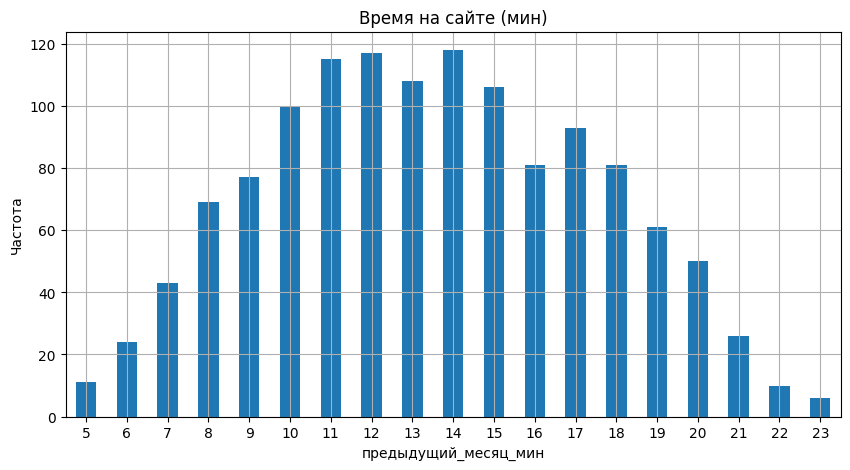

In [86]:
market_time.groupby('предыдущий_месяц_мин')['предыдущий_месяц_мин'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.title('Время на сайте (мин)')
plt.ylabel('Частота')

Время на сайте за предыдущий месяц имеет нормальное распределение.

#### ```текущий_месяц_мин```

Text(0, 0.5, 'Частота')

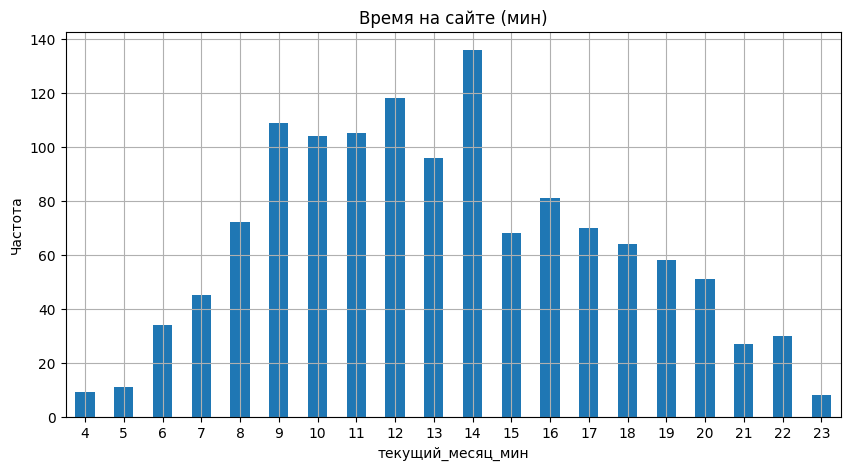

In [87]:
market_time.groupby('текущий_месяц_мин')['текущий_месяц_мин'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.title('Время на сайте (мин)')
plt.ylabel('Частота')

В текущем месяце также  время на сайте распределено равномерно, однако выбивается пик в 14 минут. Судя по тому, что соседние значения в 13 и 15 минут наоборот резко упали, можно предположить, что эти данные были неверно рассчитаны. И данные, которые должны были попасть в 13 и 15 минут, попали в 14.

#### ```всего_мин```

Text(0, 0.5, 'Частота')

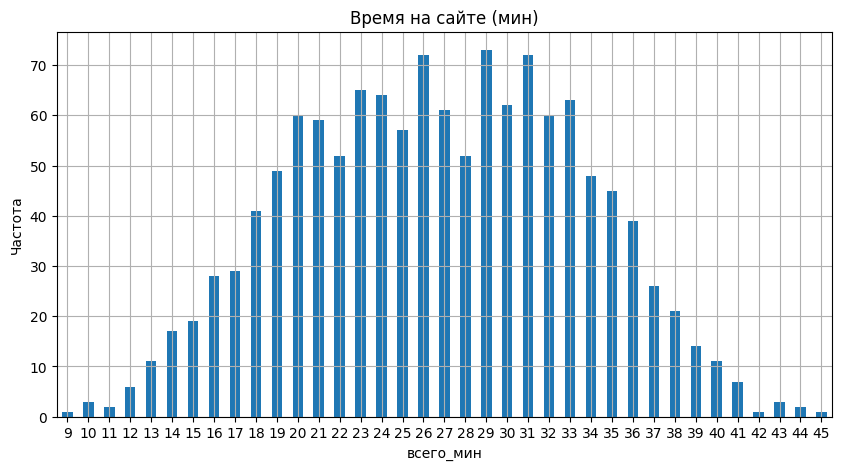

In [88]:
market_time.groupby('всего_мин')['всего_мин'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.title('Время на сайте (мин)')
plt.ylabel('Частота')

Время на сайте за 2 месяца имеет нормальное распределение.

### money

In [89]:
money.columns

Index(['id', 'прибыль'], dtype='object')

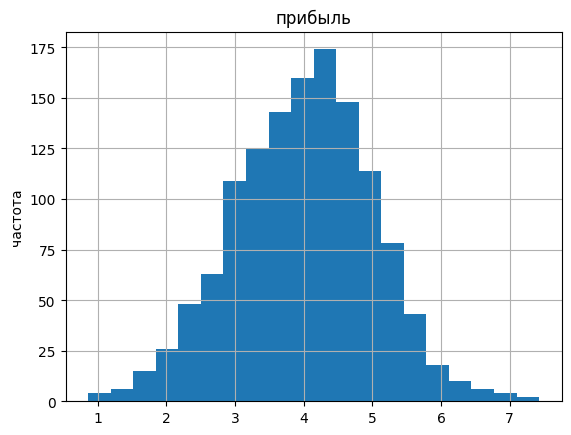

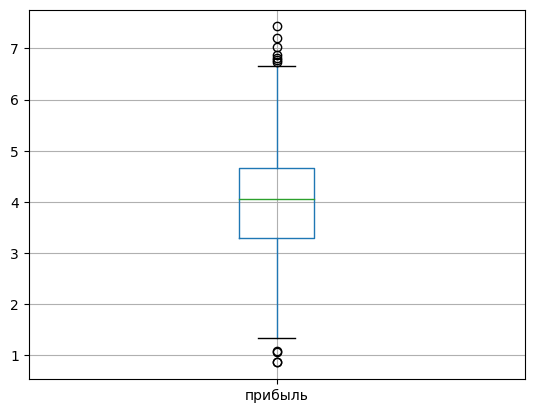

In [90]:
quant_analysis(money, 'прибыль')

Значенияя среднемесячной по клиентам распределены нормальное. Есть небольлшие выбросы. Однако, здесь прибыль, по всей видимости выражена в тысячах, поэтому умножим значения среднемесясной прибыли на 1000.

In [91]:
money['прибыль'] = money['прибыль'] * 1000
money['прибыль'].describe()

count    1296.000000
mean     3997.700617
std      1011.198207
min       860.000000
25%      3300.000000
50%      4045.000000
75%      4670.000000
max      7430.000000
Name: прибыль, dtype: float64

## Объединение таблиц

Объединим датафреймы ```market_file, market_money, market_time```.

In [92]:
market_info = market_file.join(market_money, on='id', how='inner').join(market_time, on='id', how='inner')
display(market_info.head())
display(market_info.shape[0])
market_file.shape[0]

,id,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,всего_выр,предыдущий_месяц_мин,текущий_месяц_мин,всего_мин
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,14659.6,12,10,22
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,15341.9,8,13,21
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,17561.4,11,13,24
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,16274.0,8,11,19
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,15251.0,10,10,20


1296

1296

Датафреймы объединены. Количество строк в объединенном датафрейме совпадает с количеством строк в ```market_file```. Значит во всех датафреймах все клиенты присутствуют, так как для объединения использовался параметр ```how='inner'```.

Сделаем ```id``` индексом.

In [93]:
market_info = market_info.set_index('id')
market_info.head()

,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,всего_выр,предыдущий_месяц_мин,текущий_месяц_мин,всего_мин
id,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,14659.6,12,10,22
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,15341.9,8,13,21
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,17561.4,11,13,24
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,16274.0,8,11,19
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,15251.0,10,10,20


## Корреляционный анализ

Сначала посмотрим матрицу корреляции.

<AxesSubplot:>

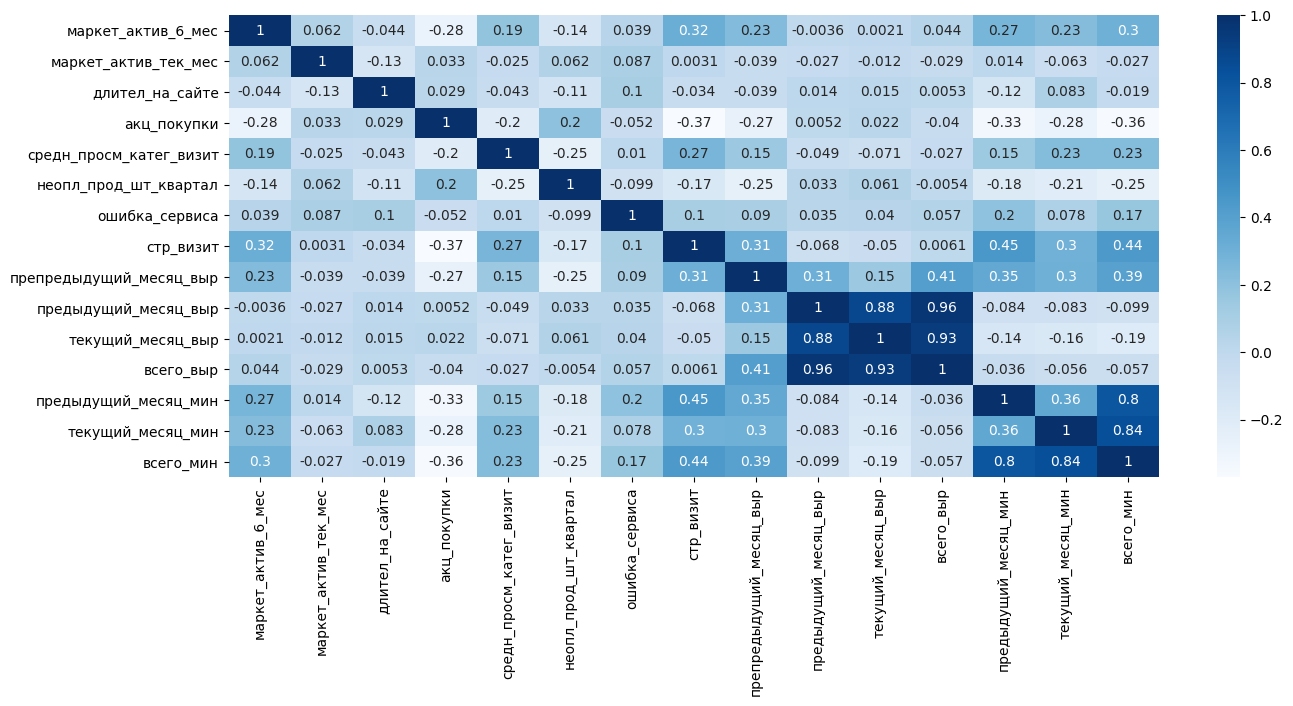

In [94]:
figure, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(market_info.corr(method='spearman'), annot=True, cmap='Blues', ax=ax)

Так как этот датафрейм будет использоваться для моделирования, удалим суммарную выручку за предыдущие 3 месяца и суммарные минуты на сайте.

In [95]:
market_info = market_info.drop(['всего_выр', 'всего_мин'], axis=1)

<AxesSubplot:>

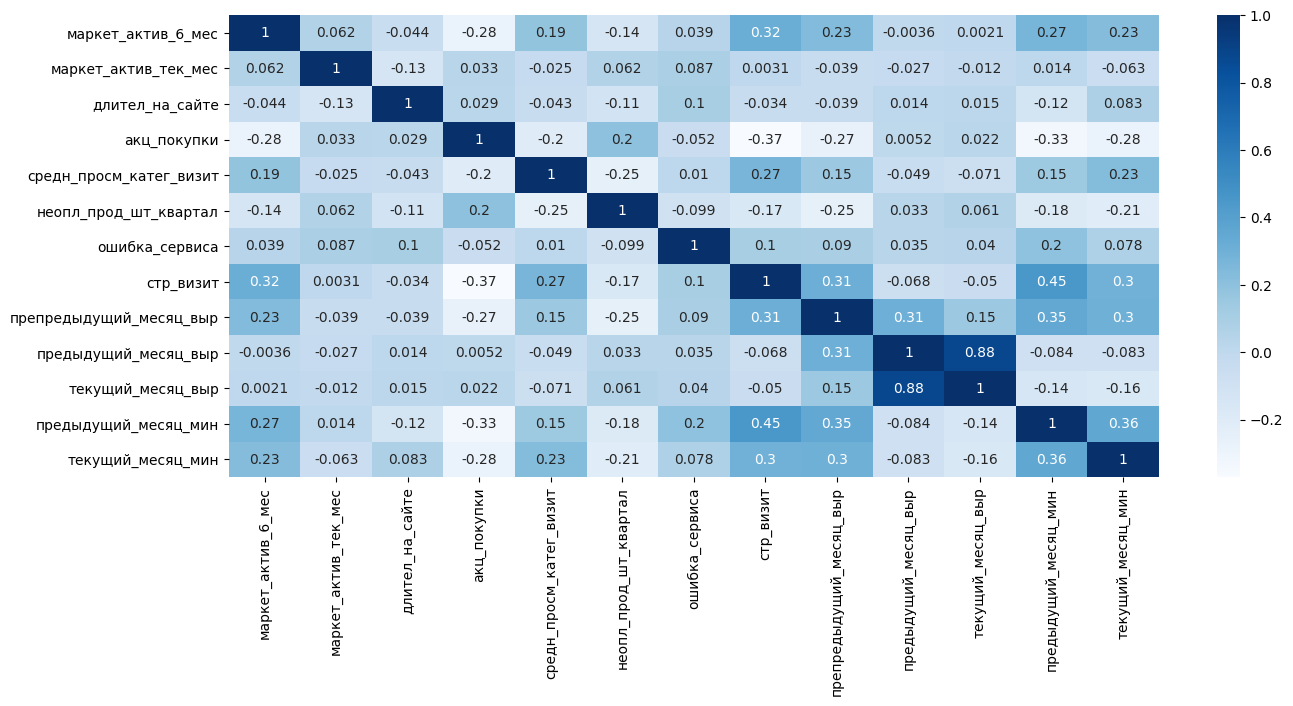

In [96]:
figure, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(market_info.corr(method='spearman'), annot=True, cmap='Blues', ax=ax)

Большой коэффициент корреляции наблюдается у выручки за текущий месяц и за предыдущий месяц. Построим диаграмму рассеяния.

<AxesSubplot:xlabel='предыдущий_месяц_выр', ylabel='текущий_месяц_выр'>

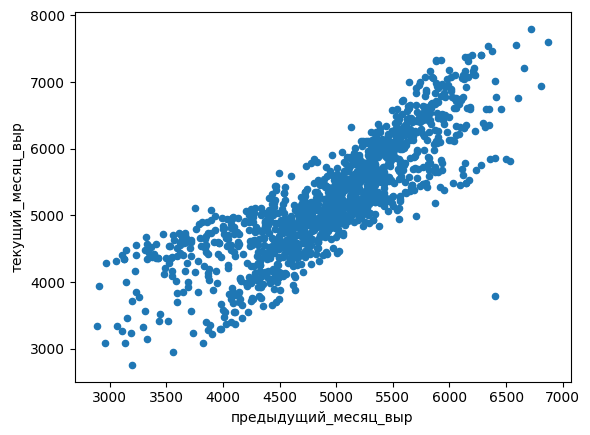

In [97]:
market_info.plot(x='предыдущий_месяц_выр', y='текущий_месяц_выр', kind='scatter')

Действительно видно, что текущий и предыдущий месяцы имеют линейную зависимость. Посмотрим теперь на препредыдущий месяц и предыдущий.

<AxesSubplot:xlabel='препредыдущий_месяц_выр', ylabel='предыдущий_месяц_выр'>

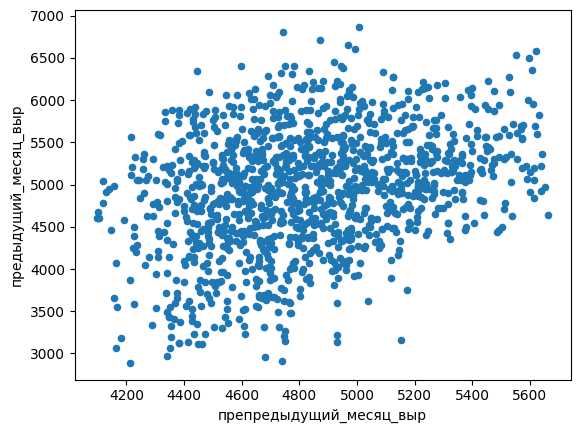

In [98]:
market_info.plot(x='препредыдущий_месяц_выр', y='предыдущий_месяц_выр', kind='scatter')

Между препредыдущем месяцем и предыдущем четкой линейной зависимости не наблюдается. Это подозрительно. Однако, каких-либо других данных, которые бы были разбиты на три крайних месяца, нет. Удалять какой-либо из столбцов ```предыдущий_месяц_выр``` и ```текущий_месяц_выр``` не имеет смысла, так как это данные за 2 последних месяца и они важны. Посмотрим также на матрицу коррреляции, учитывая категориальные признаки.

In [99]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['маркет_актив_6_мес', 'длител_на_сайте', 'акц_покупки', \
                 'неопл_прод_шт_квартал', 'ошибка_сервиса', \
                 'стр_визит', 'препредыдущий_месяц_выр', 'предыдущий_месяц_выр', 'текущий_месяц_выр', \
                 'предыдущий_месяц_мин', 'текущий_месяц_мин']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(market_info, interval_cols=interval_cols)

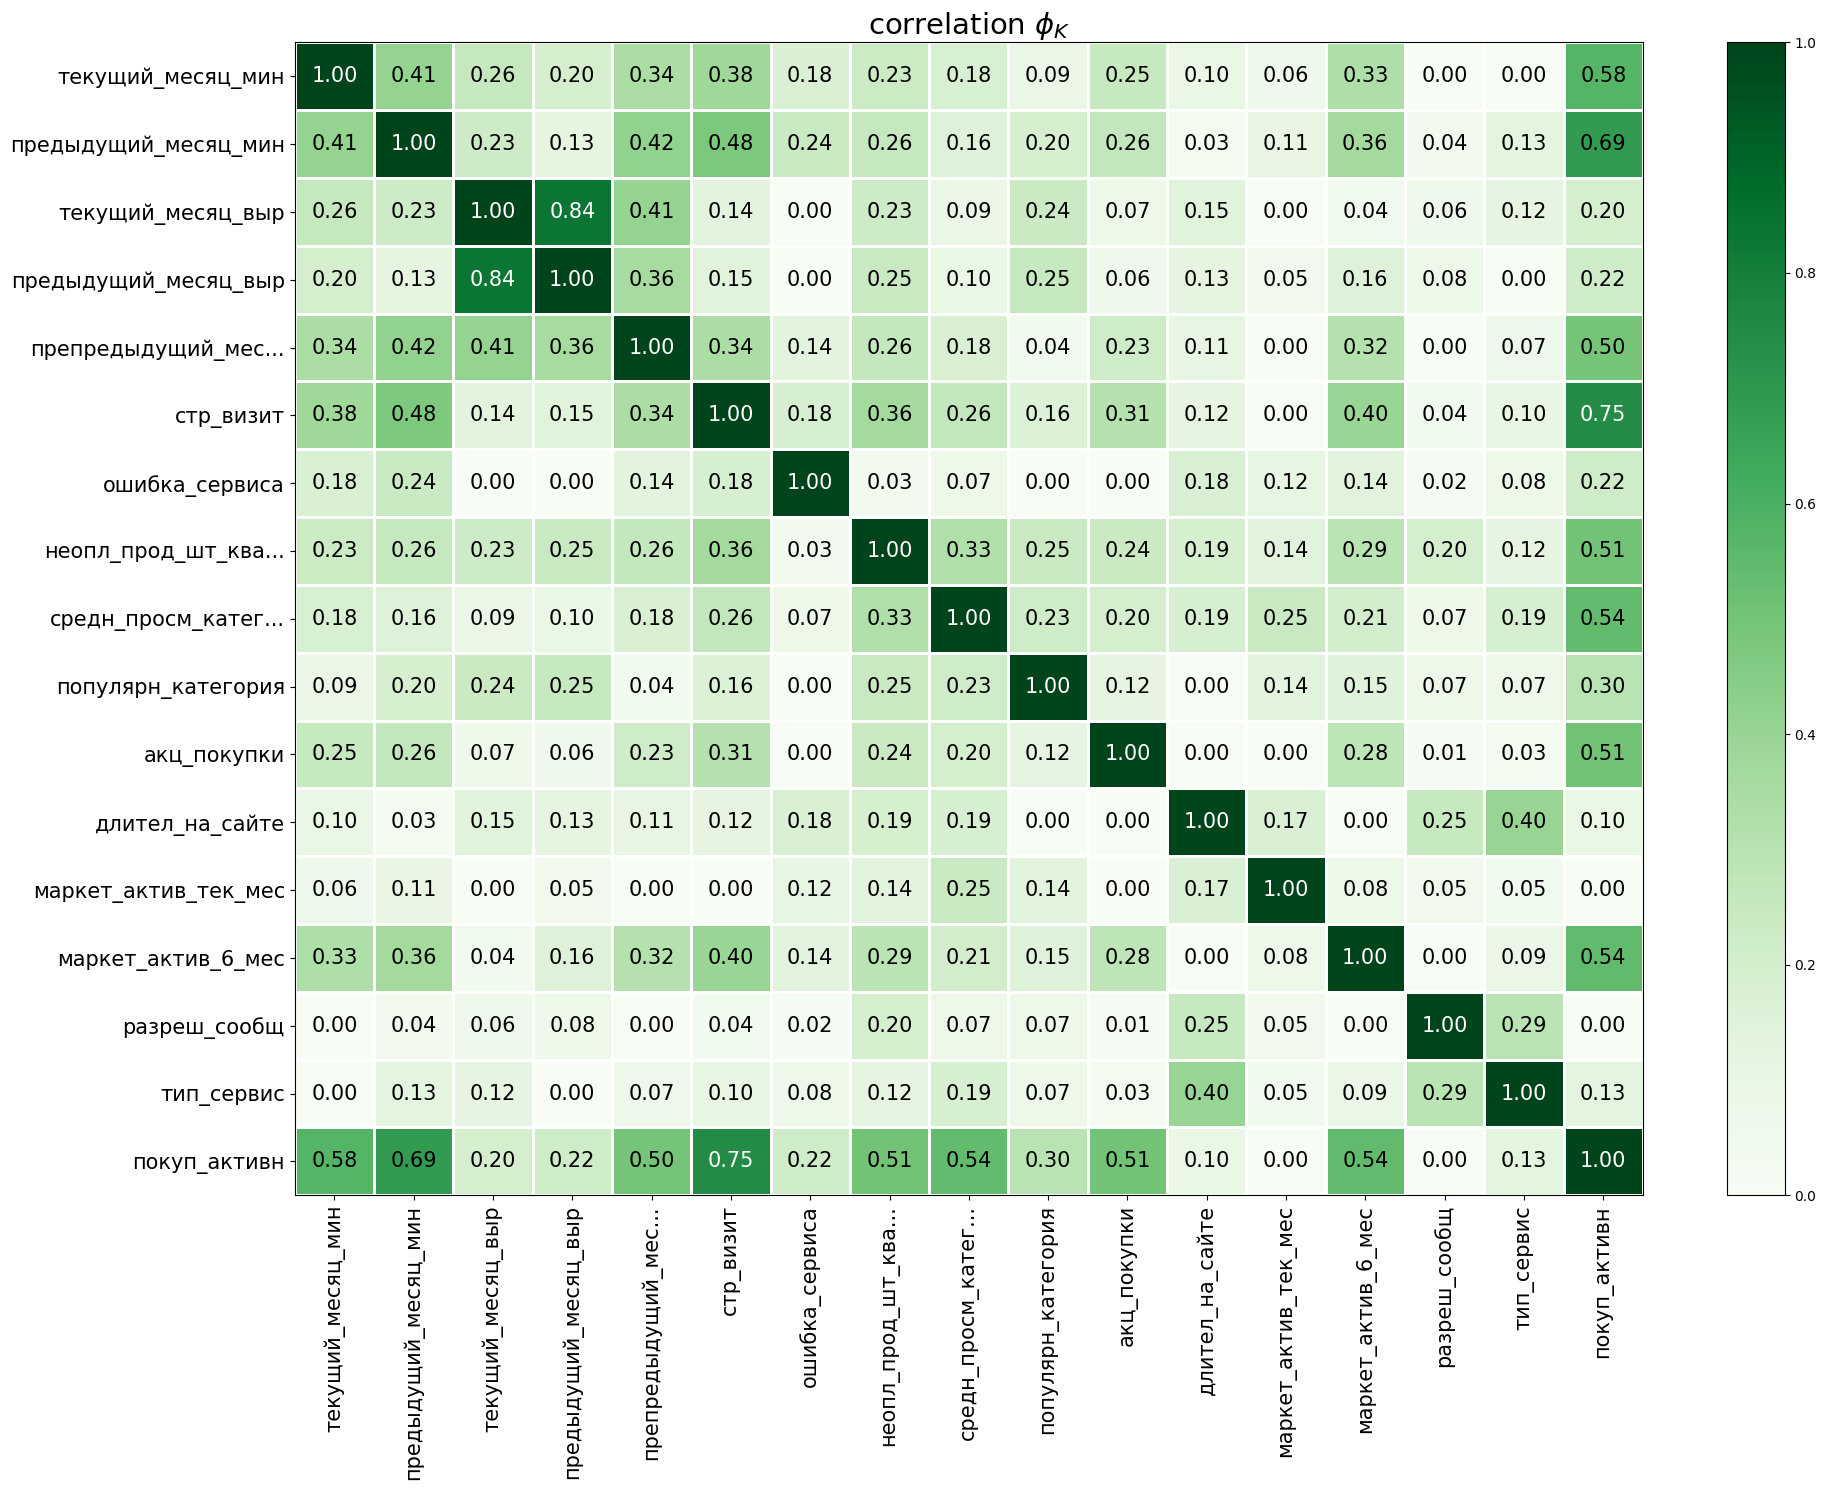

In [100]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видим, что больше всего на покупательскую активность влияют количество страниц за визит и минуты проведенные на сайте за текущий и предыдущий месяцы.

## Построение и выбор моделей

In [101]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    market_info.drop(['покуп_активн'], axis=1),
    market_info['покуп_активн'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_info['покуп_активн'])

In [103]:
ohe_columns = ['разреш_сообщ', 'популярн_категория']
ord_columns = ['тип_сервис']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длител_на_сайте', \
               'акц_покупки', 'средн_просм_катег_визит', 'неопл_прод_шт_квартал', \
               'ошибка_сервиса', 'стр_визит', 'препредыдущий_месяц_выр', \
               'предыдущий_месяц_выр', 'текущий_месяц_выр', 'предыдущий_месяц_мин', \
               'текущий_месяц_мин']

In [104]:
market_info.head()

,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,предыдущий_месяц_мин,текущий_месяц_мин
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [105]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

Проверим, что параметры ```drop='first', handle_unknown='ignore'``` работают вместе.

In [106]:
X_train_test_ohe_handle = X_train[ohe_columns].head()
# в первых 5 строках только да
X_train_test_ohe_handle.loc[215858, 'разреш_сообщ'] = 'нет'

X_test_test_ohe_handle = X_train[ohe_columns].tail()

display(X_train_test_ohe_handle)
X_test_test_ohe_handle

,разреш_сообщ,популярн_категория
id,,
215858,нет,Мелкая бытовая техника и электроника
215361,да,Техника для красоты и здоровья
215884,да,Мелкая бытовая техника и электроника
216564,да,Кухонная посуда
215715,да,Товары для детей


,разреш_сообщ,популярн_категория
id,,
216157,да,Косметика и аксесуары
216177,да,Мелкая бытовая техника и электроника
215935,да,Товары для детей
215863,нет,Мелкая бытовая техника и электроника
216030,да,Мелкая бытовая техника и электроника


In [107]:
ohe_pipe.fit(X_train_test_ohe_handle)

Pipeline(steps=[('simpleImputer_ohe',
                 SimpleImputer(add_indicator=True, strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse=False))])

In [108]:
ohe_pipe.get_feature_names_out()

array(['разреш_сообщ_нет',
       'популярн_категория_Мелкая бытовая техника и электроника',
       'популярн_категория_Техника для красоты и здоровья',
       'популярн_категория_Товары для детей'], dtype=object)

In [109]:
X_test_test_ohe_handle_transform = ohe_pipe.transform(X_test_test_ohe_handle)
X_test_test_ohe_handle_transform

D:\stude\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [110]:
X_test_test_ohe_handle_transform_df = pd.DataFrame(data=X_test_test_ohe_handle_transform, \
                                                    columns=ohe_pipe.get_feature_names_out())
X_test_test_ohe_handle_transform_df

,разреш_сообщ_нет,популярн_категория_Мелкая бытовая техника и электроника,популярн_категория_Техника для красоты и здоровья,популярн_категория_Товары для детей
0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


Таким образом, проверили, что ```drop='first'``` и ```handle_unknown='ignore'``` работают вместе.

In [111]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [112]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [113]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [114]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
#'models__kernel' : ['linear', 'poly', 'rbf'],

In [115]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разреш_сообщ',
                                                   'популярн_категория']),
    

Лучшей моделью была выбрана SVC(C=1).

Так как нельзя сказать, что лучше, отправить рекламу пользователям, чья активность не снизится и они возможно будут раздражены рекламой или не отправить тем, чья покупательская активность снизится, будем использовать наиболее общую метрику ROC-AUC.

In [116]:
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9123892731464629


На тестовой выброке модель показала хороший результат.

## Анализ важности признаков

Сначала преобразуем данные и инициализируем лучшую модель.

In [117]:
# получим лучший пайплайн с лучшей моделью и преобразованием данных
best_pipeline = randomized_search.best_estimator_

In [118]:
# получим преобразование данных
best_preprocessor = best_pipeline['preprocessor']

In [119]:
# преобразуем данные
X_train_transformed = best_preprocessor.transform(X_train)
X_test_transformed = best_preprocessor.transform(X_test)

In [120]:
# получим имена признаков
feature_names = best_preprocessor.get_feature_names_out()
feature_names

array(['ohe__разреш_сообщ_нет',
       'ohe__популярн_категория_Косметика и аксесуары',
       'ohe__популярн_категория_Кухонная посуда',
       'ohe__популярн_категория_Мелкая бытовая техника и электроника',
       'ohe__популярн_категория_Техника для красоты и здоровья',
       'ohe__популярн_категория_Товары для детей', 'ord__тип_сервис',
       'num__маркет_актив_6_мес', 'num__маркет_актив_тек_мес',
       'num__длител_на_сайте', 'num__акц_покупки',
       'num__средн_просм_катег_визит', 'num__неопл_прод_шт_квартал',
       'num__ошибка_сервиса', 'num__стр_визит',
       'num__препредыдущий_месяц_выр', 'num__предыдущий_месяц_выр',
       'num__текущий_месяц_выр', 'num__предыдущий_месяц_мин',
       'num__текущий_месяц_мин'], dtype=object)

In [121]:
# создадим датафреймы тренировочной и тестовой выборок
X_train_transformed_df = pd.DataFrame(data=X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(data=X_test_transformed, columns=feature_names)
X_test_transformed_df.head()

,ohe__разреш_сообщ_нет,ohe__популярн_категория_Косметика и аксесуары,ohe__популярн_категория_Кухонная посуда,ohe__популярн_категория_Мелкая бытовая техника и электроника,ohe__популярн_категория_Техника для красоты и здоровья,ohe__популярн_категория_Товары для детей,ord__тип_сервис,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длител_на_сайте,num__акц_покупки,num__средн_просм_катег_визит,num__неопл_прод_шт_квартал,num__ошибка_сервиса,num__стр_визит,num__препредыдущий_месяц_выр,num__предыдущий_месяц_выр,num__текущий_месяц_выр,num__предыдущий_месяц_мин,num__текущий_месяц_мин
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.169629,-0.034940,-0.003856,-0.678649,2.045527,-0.927589,-0.099707,0.961202,0.214194,-1.405144,-2.320463,0.624051,0.894668
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.866015,-0.034940,0.307182,2.517826,-0.183455,1.542593,-1.646221,-0.557143,-0.540665,-2.013227,-1.271572,-0.647600,-1.024488
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.968558,-0.034940,-0.474402,-0.759573,0.559539,-0.433553,1.962313,0.455087,-0.808993,0.699537,1.304666,1.641373,-0.544699
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.768826,-1.450017,1.794585,0.130585,0.559539,0.060484,0.415798,-0.557143,0.453036,2.359246,1.807872,-1.156261,-1.024488
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.228498,-0.034940,-1.834199,2.720134,-1.669444,-0.433553,-0.615212,-0.304085,-1.145141,0.193040,0.635946,0.369721,1.134563


In [122]:
# получим лучшую модель
best_model = best_pipeline.named_steps['models']
best_model

SVC(C=1, probability=True, random_state=42)

  0%|          | 0/100 [00:00<?, ?it/s]

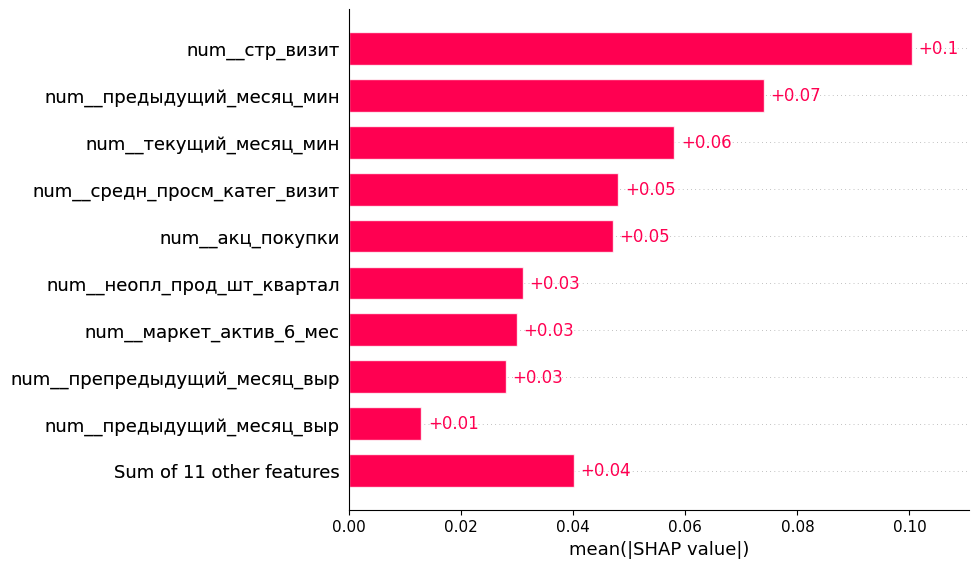

In [123]:
background_data = shap.sample(X_train_transformed_df, 50)
explainer = shap.KernelExplainer(best_model.predict_proba, background_data)
shap_values = explainer(X_test_transformed_df[:100])
shap.plots.bar(shap_values[:, :, 1])

Таким образом, наиболее важными параметрами, влияющими на активность покупателей является среднее количество просмотренных за визит страниц. Также, важно количество минут проведенных пользователем в предыдущем и текущем месяце на сайте. Из необычных результатов можно выделить, что также важными оказываются признаки среднего просмотра категорий за визит, покупки по акции, а также активность маркетингов коммуникаций за последние 6 месяцев.

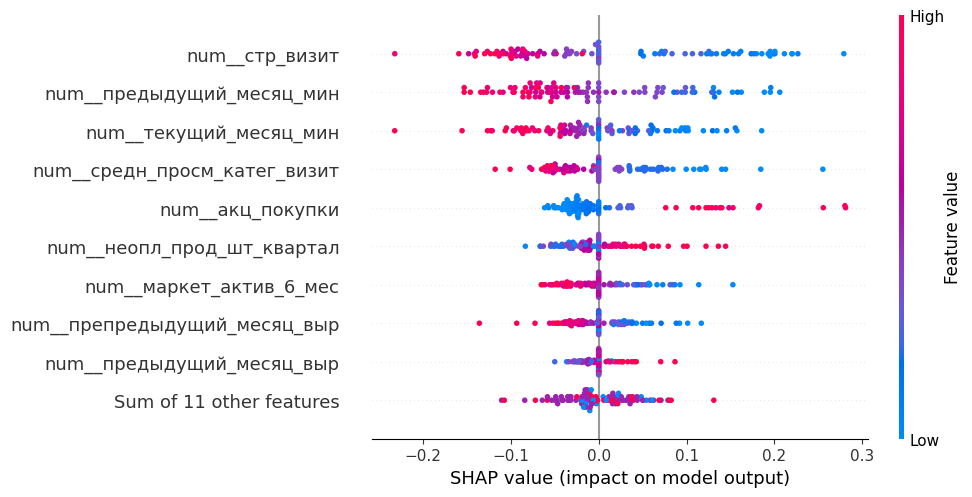

In [124]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [125]:
# проверим какое значение модель понимает как 0, а какое как 1
best_model.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

Получается, что класс 1 - это "Снизилась". Тогда видим, что при увеличении среднего количества просмотренных страниц за визит модель склоняется к тому, чтобы присвоить значение 0, то есть, что активность осталась на прежнем уровне. Но интересно, что при увеличении процента покупок по акции, модель склоняется к присвоению класса снижения покупательской активности. Возможно, это связано с тем, что такие покупатели только ждут акций и не являются постоянно активными клиентами. То есть стоит учесть, что клиентам с высокой долей акционных покупок, стоит предлагать больше акций, когда и если это возможно.

## Сегментация покупателей

Выделим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Но сначала рассчитаем вероятности снижения активности для всех клиентов.

In [126]:
y_pred_all = randomized_search.predict_proba(market_info.drop('покуп_активн', axis=1))

In [127]:
market_info['вер_снижения'] = y_pred_all[:, 1]
market_info.head()

,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,предыдущий_месяц_мин,текущий_месяц_мин,вер_снижения
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,0.980205
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,0.555294
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,0.815607
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,0.946650
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,0.814474


Теперь добавим в датафрейм данные по прибыльности клиентов.

In [128]:
# сделаем id индексом
money = money.set_index('id')
money.head()

,прибыль
id,
215349,4160.0
215350,3130.0
215351,4870.0
215352,4210.0
215353,3950.0


In [129]:
display(market_info.shape[0])
market_info = market_info.join(money, on='id', how='inner')
display(market_info.shape[0])
market_info.head()

1296

1296

,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,предыдущий_месяц_мин,текущий_месяц_мин,вер_снижения,прибыль
id,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,0.980205,4160.0
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,0.555294,3130.0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,0.815607,4870.0
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,0.946650,4210.0
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,0.814474,3950.0


Прибыльность добавлена для всех клиентов, так как количество строк осталось прежним.

Посмотрим на статистические значения прибыльности.

In [130]:
market_info['прибыль'].describe()

count    1296.000000
mean     3997.700617
std      1011.198207
min       860.000000
25%      3300.000000
50%      4045.000000
75%      4670.000000
max      7430.000000
Name: прибыль, dtype: float64

Возьмем в качестве фильтра значение третьего квартиля. То есть наиболее важными клиентами будет считать тех, прибыль от которых больше 4670. Теперь посмотрим на статистические значения вероятности снижения активности.

In [131]:
market_info['вер_снижения'].describe()

count    1296.000000
mean        0.380265
std         0.389778
min         0.010842
25%         0.075473
50%         0.125767
75%         0.921344
max         0.999989
Name: вер_снижения, dtype: float64

Аналогично воспользуемся значением третьего квартиля 0.92. То есть отберем клиентов, для которых вероятность снижения активности больше третьего квартиля.

In [132]:
target_group = market_info[(market_info['вер_снижения'] > market_info['вер_снижения'].quantile(0.75)) \
                           & (market_info['прибыль'] > market_info['прибыль'].quantile(0.75))]
target_group

,покуп_активн,тип_сервис,разреш_сообщ,маркет_актив_6_мес,маркет_актив_тек_мес,длител_на_сайте,акц_покупки,популярн_категория,средн_просм_катег_визит,неопл_прод_шт_квартал,ошибка_сервиса,стр_визит,препредыдущий_месяц_выр,предыдущий_месяц_выр,текущий_месяц_выр,предыдущий_месяц_мин,текущий_месяц_мин,вер_снижения,прибыль
id,,,,,,,,,,,,,,,,,,,
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4433.0,4146.5,4566.4,6,7,0.979132,4930.0
215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,4536.0,5823.0,5591.6,11,9,0.987480,6270.0
215385,Снизилась,стандарт,да,3.6,4,721,0.24,Домашний текстиль,5,3,4,4,4707.0,6184.5,6627.8,10,8,0.972405,4850.0
215388,Снизилась,стандарт,да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,4182.0,3188.0,3232.2,10,12,0.955827,5160.0
215391,Снизилась,премиум,да,3.5,3,754,0.30,Косметика и аксесуары,3,1,2,1,4556.0,5928.5,5824.5,10,11,0.984349,5440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215737,Снизилась,стандарт,да,0.9,4,225,0.36,Косметика и аксесуары,2,4,2,3,4679.0,5126.0,5291.1,9,10,0.969062,4800.0
215738,Снизилась,премиум,нет,4.6,5,187,0.23,Мелкая бытовая техника и электроника,1,3,3,2,4500.0,4773.0,4445.4,9,7,0.987273,5250.0
215739,Снизилась,стандарт,нет,3.4,4,875,0.25,Мелкая бытовая техника и электроника,2,3,1,3,4258.0,5186.5,5156.6,9,9,0.985183,4810.0


Рассмотрим полученную группу покупателей.

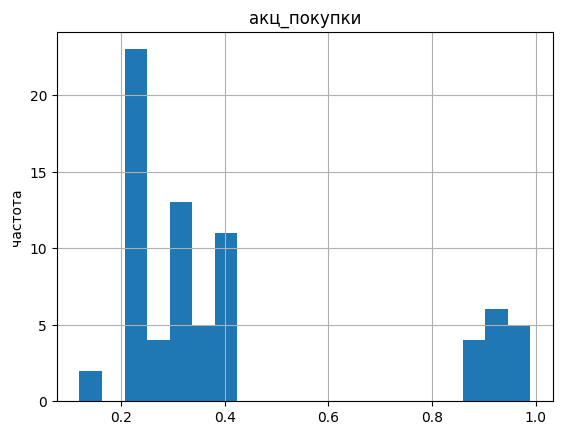

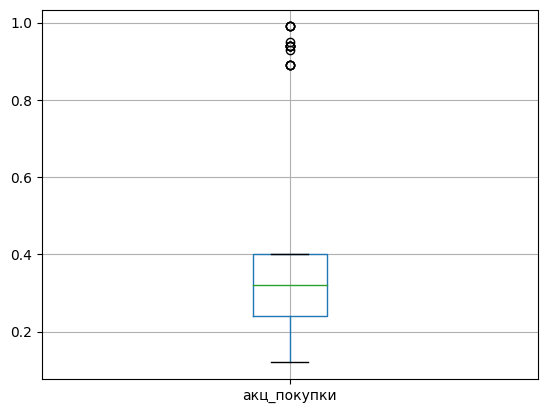

In [133]:
quant_analysis(target_group, 'акц_покупки')

Видим, что среди клиентов целевой группы большое количество покупок по акциям рассматривается как выбросы. То есть в целом, целевая группа не нацелена исключительно на акции.

Сравним среднее количество просмотров категорий за визит для целевой группы и в целом для всех.

Text(0.5, 1.0, 'Распределение среднего количества просмотров за визит')

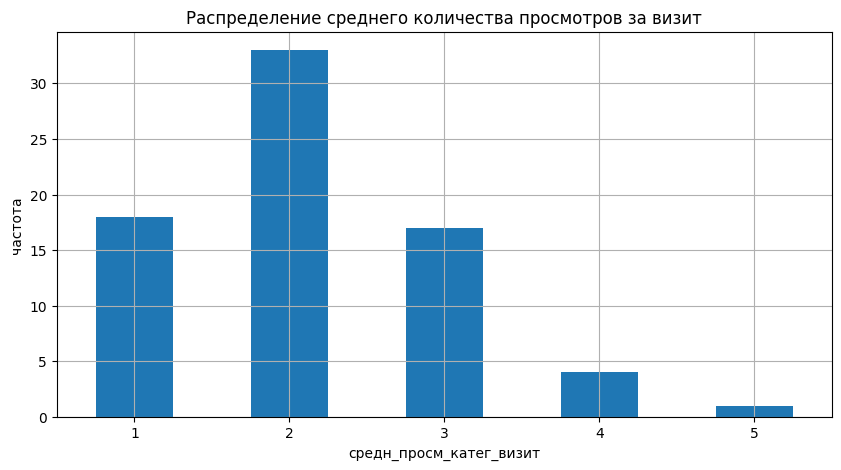

In [134]:
target_group.groupby('средн_просм_катег_визит')['средн_просм_катег_визит'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.ylabel('частота')
plt.title('Распределение среднего количества просмотров за визит')

Text(0.5, 1.0, 'Распределение среднего количества просмотров за визит')

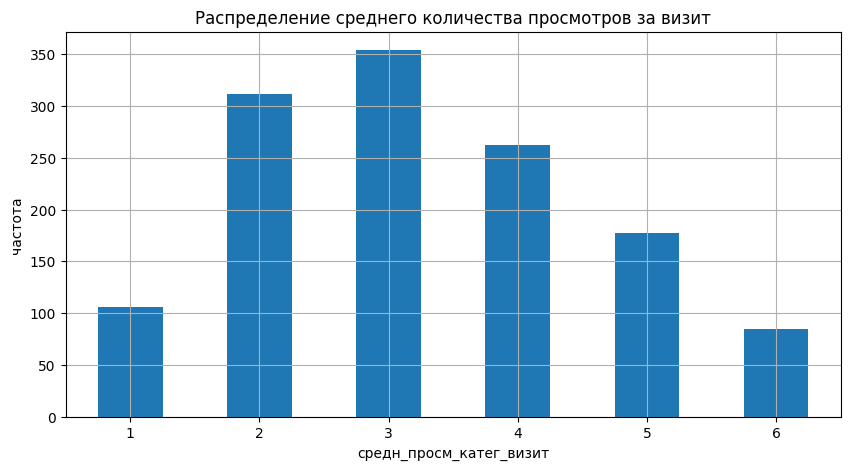

In [135]:
market_info.groupby('средн_просм_катег_визит')['средн_просм_катег_визит'].agg('count').plot.bar(rot=0, grid=True, figsize=(10, 5))
plt.ylabel('частота')
plt.title('Распределение среднего количества просмотров за визит')

Видим, что для целевой группы мода сдвинута влево относительно всех клиентов. То есть целевая группа просматривает меньше категорий за визит.

Text(0.5, 1.0, 'Распределение количества ошибок сервиса')

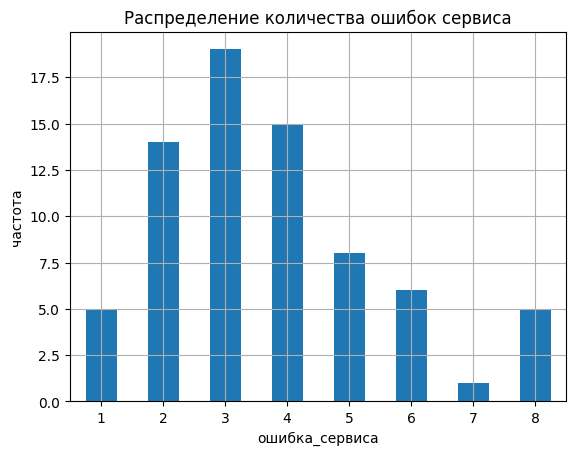

In [136]:
target_group.groupby('ошибка_сервиса')['ошибка_сервиса'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение количества ошибок сервиса')

Text(0.5, 1.0, 'Распределение количества ошибок сервиса')

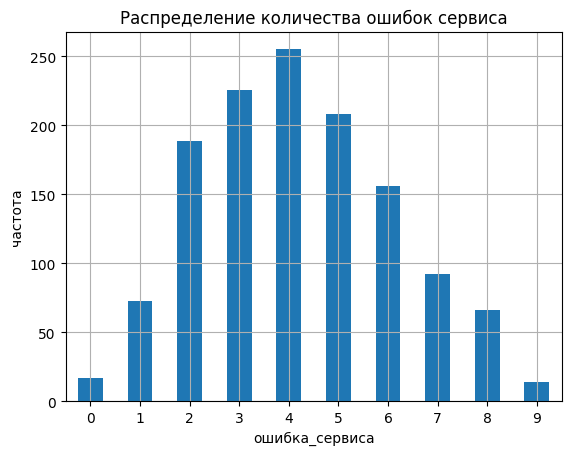

In [137]:
market_info.groupby('ошибка_сервиса')['ошибка_сервиса'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение количества ошибок сервиса')

Видим, что клиенты целевой группы достаточно часто сталкиваются с ошибками на сервисе. Несмотря на то, что мода сдвинута влево относительно всех клиентов, видим также, что у целевых покупателей отсутствуют случаи, когда они совсем не сталкиваются с ошибками сервиса.

Text(0.5, 1.0, 'Распределение неоплаченных продуктов в корзине (шт)')

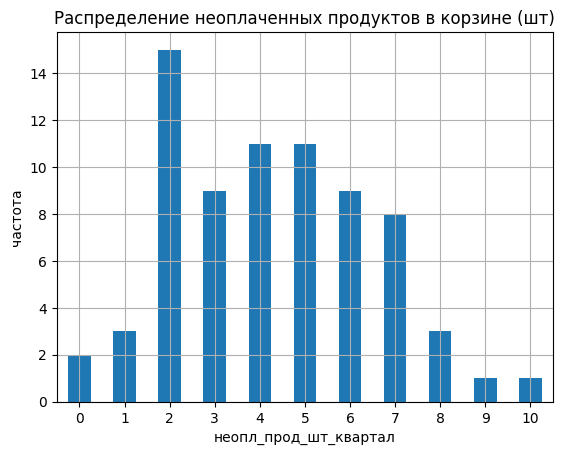

In [138]:
target_group.groupby('неопл_прод_шт_квартал')['неопл_прод_шт_квартал'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение неоплаченных продуктов в корзине (шт)')

Text(0.5, 1.0, 'Распределение неоплаченных продуктов в корзине (шт)')

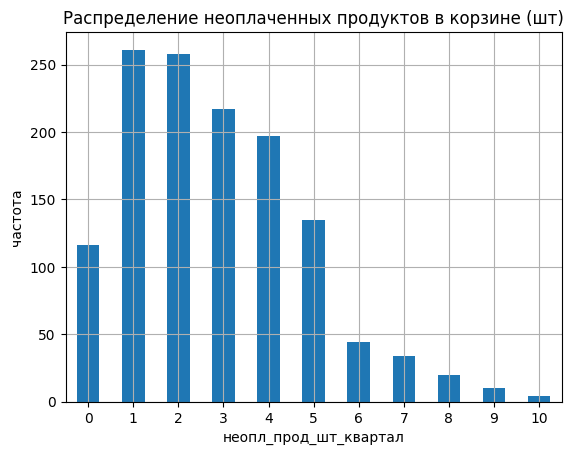

In [139]:
market_info.groupby('неопл_прод_шт_квартал')['неопл_прод_шт_квартал'].agg('count').plot.bar(rot=0, grid=True)
plt.ylabel('частота')
plt.title('Распределение неоплаченных продуктов в корзине (шт)')

У целевой группы много клиентов, у которых в корзине лежат две неоплаченные покупки.

In [140]:
target_group['неопл_прод_шт_квартал'].describe()

count    73.000000
mean      4.273973
std       2.206432
min       0.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      10.000000
Name: неопл_прод_шт_квартал, dtype: float64

In [141]:
market_info['неопл_прод_шт_квартал'].describe()

count    1296.000000
mean        2.841821
std         1.974074
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неопл_прод_шт_квартал, dtype: float64

И по сравнению со всеми клиентами видим сдвиг вправо. То есть в среднем у целевой группы больше неоплаченных покупок.

Для сохранения активности рассмотренного сегмента покупателей бизнесу можно предложить увеличить количество специальных предложений с акциями для этих пользователей. Этот сегмент является прибыльным, но при этом наиболее вероятен в части снижения активности. Также мы увидили, что у этих клиентов много неоплаченных покупок в корзине. То есть, возможно, они хотят купить конкретные товары, так как в среднем просматривают меньше категорий (что может говорить об их нацеленности на определенные товары), но считают их слишком дорогими. А так как в целевой группе в целом не наблюдается тенденция покупок только по акциям, можно предложить им специальные акции на интересующие их товары для сохранения их активности.

## Общий вывод

Интернет-магазин "В один клик" начал фиксировать снижение активности пользователей. В качестве решения указанной проблемы было предложено использовать персонализированные предложения. Для более точного использования персонализированных предложений необходимо было построить модель машинного обучения, которая бы предсказывала вероятность снижения активности пользователей. Затем необходимо было провести сегментацию клиентов для создания персонализированных предложений.

Исходными данными были четыре таблице с различными параметрами, описывающими поведение клиентов. В качестве предобработки данных были изменены наименования столбцов и заменены неявные дубликаты. Из всех таблиц были удалены три пользователя, которые не совершали покупки в каждом из последних трех месяцев. Три таблицы были объединены в одну для исследования влияния всех признаков на активность клиентов. Проведен корреляционный анализ.

Был задан пайплайн для поиска лучшей модели с лучшими гиперпараметрами. В результате обучения пайплайна лучшей моделью, согласно метрике ROC-AUC, стала SVC(C=1). Затем были оценены важности признаков. Также на основе указанной модели были рассчитаны вероятности снижения активности клиентов в ближайшие три месяца. Был выделен сегмент наиболее прибыльных для "В один клик" пользователей с наибольшей вероятностью снижения активности. Изучение этого сегмента показало, что такие клиенты имеют много неоплаченных покупок в корзине. Поэтому, было предложено использование персонализированных акций для сохранения активности клиентов целевого сегмента.